In [91]:
from u_cmab import Train, qini
import pandas as pd
import torch.nn as nn
import torch

In [2]:
data = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
data["segment"] = data["segment"].astype("category")
data["history_segment"] = data["history_segment"].astype("category")
data["zip_code"] = data["zip_code"].astype("category")
data["channel"] = data["channel"].astype("category")

data_size = data.shape[0]

In [3]:
def parse_data_hillstrom(data):
    context = data[["recency", "history_segment", "history", "mens", "womens", "zip_code", "newbie", "channel"]].copy()
    treatment = data["segment"]
    reward = data["visit"]

    one_hot_hs = pd.get_dummies(context["history_segment"], prefix="hs")
    one_hot_zc = pd.get_dummies(context["zip_code"], prefix="zc")
    one_hot_c = pd.get_dummies(context["channel"], prefix="c")

    context = pd.concat([context[["recency", "history", "mens", "womens", "newbie"]], one_hot_hs, one_hot_zc, one_hot_c], axis=1)

    return (context.values, treatment.values, reward.values)

In [114]:
import numpy as np
from pylift.eval import UpliftEval
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 22
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20



def plotting(ts, rs, u_hats, ups, treatment_names=['T=1'], urf_label=['Uplift Random Forest'], urf_colors=['firebrick'], urf_colors_bands=['deeppink'], yticks=[0, 0.04]):
    fig, ax = plt.subplots()
    
    for r in range(len(u_hats)):
        
        b_x, b_y, s_x, s_y, rand = [], [], [], [], []

        for i in range(len(u_hats[r])):		
            ue = UpliftEval(ts[r][i], rs[r][i], u_hats[r][i])
            x, y = ue.calc('aqini')
            x_stat, y_stat = ups[r][i].test_results_.calc(plot_type='aqini', n_bins=20)

            b_x.append(x)
            b_y.append(y)
            s_x.append(x_stat)
            s_y.append(y_stat)

            rand.append(getattr(ue, 'aqini_y')[-1])



        b_x_avg = np.average(b_x, axis=0)
        b_y_avg = np.average(b_y, axis=0)

        s_x_avg = np.average(s_x, axis=0)
        s_y_avg = np.average(s_y, axis=0)

        b_y_std = np.std(b_y, axis=0)
        s_y_std = np.std(s_y, axis=0)




        nn_label = "_no_label_" if r > 0 else 'Batch ANN'
        random_label = "_no_label_" if r < (len(u_hats)-1) else 'Random selection'
        
        ax.plot(b_x_avg, b_y_avg,'.-', color='dodgerblue', label=nn_label, markersize=13, linewidth=3, zorder=103)
        
        ax.plot(s_x_avg, s_y_avg,'.-', color=urf_colors[r], label=urf_label[r], markersize=13, linewidth=3, zorder=102)
        ax.plot([0,1], [0, np.average(rand)], '--', color='black', label=random_label, linewidth=3, dashes=(5,5), zorder=0)
        ax.text(.95, np.average(rand) - .1*yticks[-1], treatment_names[r], horizontalalignment='left')
        
        
        ax.fill_between(
            b_x_avg, b_y_avg - b_y_std, b_y_avg + b_y_std, **{"color": "turquoise", "alpha": .22, "linewidth":0, "zorder": 101}
        )

        ax.fill_between(
            s_x_avg, s_y_avg - s_y_std, s_y_avg + s_y_std, **{"color": urf_colors_bands[r], "alpha": .15, "linewidth":0, "zorder": 100}
        )


    ax.title.set_fontsize(30)
    ax.title.set_text("Hillstrom dataset")
    ax.title.set_fontfamily("sans-serif")
    ax.xaxis.label.set_fontsize(30)
    ax.xaxis.label.set_fontfamily("sans-serif")
    ax.xaxis.label.set_text('Fraction of data')

    ax.yaxis.label.set_fontsize(30)
    ax.yaxis.label.set_fontfamily("sans-serif")
    ax.yaxis.label.set_text('Uplift')

    ax.set_yticks(yticks)
    ax.set_xticks([0, .5, 1])

    ax.xaxis.set_tick_params(labelsize=30)
    ax.yaxis.set_tick_params(labelsize=30)

    ax.figure.set_size_inches(13.5, 10.5)

    font = fm.FontProperties(family='sans-serif', size=23)

    ax.legend(prop=font)

    return ax

In [5]:
hidden = 35
context_n = 18
treatment_n = 3

forests_m = []
forests_w = []
nets_m = []
nets_w = []
treats_m = []
treats_w = []
resps_m = []
resps_w = []

In [31]:
runs = 5
for i in range(runs):
    t = Train(data, parse_data_hillstrom)
    
    # 2 RF's
    u_w = t.rf(segment="w")
    u_m = t.rf(segment="m")
    
    # 1 NET
    net = nn.Sequential(
        nn.Linear(context_n, 36),
        nn.ReLU(),
        nn.Linear(36, 36),
        nn.ReLU(),
        nn.Linear(36, 36),
        nn.ReLU(),
        nn.Linear(36, 18),
        nn.ReLU(),
        nn.Linear(18, treatment_n)
    )
    t.nn(net, epochs=400, weight_decay=0, loss_f=nn.SmoothL1Loss(), batch_size=32, learning_rate=1e-5)
    
    # Calculate results of single net for 2 groups (w and m)
    c_w, tr_w, r_w = parse_data_hillstrom(t.test_data_w)
    c_m, tr_m, r_m = parse_data_hillstrom(t.test_data_m)

    tr_w = tr_w.codes - 1
    tr_m = abs(tr_m.codes - 1)
        
    res_w = net(torch.tensor(c_w, dtype=torch.float, requires_grad=False))
    u_hat_w = (res_w[:,2] - res_w[:,1]).detach().numpy()
    res_m = net(torch.tensor(c_m, dtype=torch.float, requires_grad=False))
    u_hat_m = (res_m[:,0] - res_m[:,1]).detach().numpy()
    
    
    # Document results
    forests_w.append(u_w)
    forests_m.append(u_m)
    nets_w.append(u_hat_w)
    nets_m.append(u_hat_m)
    treats_w.append(tr_w)
    treats_m.append(tr_m)
    resps_w.append(r_w)
    resps_m.append(r_m)
    
    print(f"END OF RUN {i+1}")

/Users/jeroen/Documents/PhD/research/self/seq_UM/RL1/code/KDD19/u_cmab/data_test.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data['strat'] = self.data["segment"].astype(str) + self.data["visit"].astype(str)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   32.4s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   42.9s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value fo

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   27.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   36.4s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


epoch 0 done with avg training loss of 0.037793783878774516
epoch 1 done with avg training loss of 0.020962679240453457
epoch 2 done with avg training loss of 0.020832164998698447
epoch 3 done with avg training loss of 0.020777242122983028
epoch 4 done with avg training loss of 0.020735061506275087
epoch 5 done with avg training loss of 0.020709608563255252
epoch 6 done with avg training loss of 0.020680150054062582
epoch 7 done with avg training loss of 0.02067015405611268
epoch 8 done with avg training loss of 0.020655444364362795
epoch 9 done with avg training loss of 0.02063695478286328
epoch 10 done with avg training loss of 0.020640597747239683
epoch 11 done with avg training loss of 0.020634538147299153
epoch 12 done with avg training loss of 0.020610569421468036
epoch 13 done with avg training loss of 0.020608454601440045
epoch 14 done with avg training loss of 0.020589715117322546
epoch 15 done with avg training loss of 0.020592404077095644
epoch 16 done with avg training loss

epoch 135 done with avg training loss of 0.020263633694765824
epoch 136 done with avg training loss of 0.020251148122562363
epoch 137 done with avg training loss of 0.020254741410026325
epoch 138 done with avg training loss of 0.020243849731050433
epoch 139 done with avg training loss of 0.020256157372579246
epoch 140 done with avg training loss of 0.020247449103709576
epoch 141 done with avg training loss of 0.02024805597129411
epoch 142 done with avg training loss of 0.020252397170988843
epoch 143 done with avg training loss of 0.020237257244298236
epoch 144 done with avg training loss of 0.020242640156897584
epoch 145 done with avg training loss of 0.020239851072796487
epoch 146 done with avg training loss of 0.02023487266369297
epoch 147 done with avg training loss of 0.02023203240873824
epoch 148 done with avg training loss of 0.020233240296864616
epoch 149 done with avg training loss of 0.020236741921565098
epoch 150 done with avg training loss of 0.020231449812085234
epoch 151 d

epoch 268 done with avg training loss of 0.020182086535164023
epoch 269 done with avg training loss of 0.02017651628852556
epoch 270 done with avg training loss of 0.020180328053455533
epoch 271 done with avg training loss of 0.0201962229315125
epoch 272 done with avg training loss of 0.020186335032173833
epoch 273 done with avg training loss of 0.020185702535922508
epoch 274 done with avg training loss of 0.020178250081205207
epoch 275 done with avg training loss of 0.020184968445017666
epoch 276 done with avg training loss of 0.020175899525306056
epoch 277 done with avg training loss of 0.020179754238342867
epoch 278 done with avg training loss of 0.020186760696316405
epoch 279 done with avg training loss of 0.020178078109830883
epoch 280 done with avg training loss of 0.02018445821262763
epoch 281 done with avg training loss of 0.02017959028914837
epoch 282 done with avg training loss of 0.020176319667537298
epoch 283 done with avg training loss of 0.02017727514512704
epoch 284 done

/Users/jeroen/Documents/PhD/research/self/seq_UM/RL1/code/KDD19/u_cmab/data_test.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data['strat'] = self.data["segment"].astype(str) + self.data["visit"].astype(str)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   31.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   44.5s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value fo

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   30.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   41.4s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


epoch 0 done with avg training loss of 0.03264476906375161
epoch 1 done with avg training loss of 0.022443919911248875
epoch 2 done with avg training loss of 0.021981186105237742
epoch 3 done with avg training loss of 0.021690057413652538
epoch 4 done with avg training loss of 0.02148571717336641
epoch 5 done with avg training loss of 0.021315716777296205
epoch 6 done with avg training loss of 0.02118915133793572
epoch 7 done with avg training loss of 0.021100022084345776
epoch 8 done with avg training loss of 0.02102722900736678
epoch 9 done with avg training loss of 0.020963382987538352
epoch 10 done with avg training loss of 0.020926375648871596
epoch 11 done with avg training loss of 0.02088253882630462
epoch 12 done with avg training loss of 0.020858895364550076
epoch 13 done with avg training loss of 0.020844971076585353
epoch 14 done with avg training loss of 0.020817351057859403
epoch 15 done with avg training loss of 0.020798464317839327
epoch 16 done with avg training loss of

epoch 135 done with avg training loss of 0.0202346483486638
epoch 136 done with avg training loss of 0.02024321254874979
epoch 137 done with avg training loss of 0.02023523241381294
epoch 138 done with avg training loss of 0.020244864399511633
epoch 139 done with avg training loss of 0.020235135784106593
epoch 140 done with avg training loss of 0.02023605108760031
epoch 141 done with avg training loss of 0.02023491971826713
epoch 142 done with avg training loss of 0.020236901878545592
epoch 143 done with avg training loss of 0.020228948437143117
epoch 144 done with avg training loss of 0.020235294900235852
epoch 145 done with avg training loss of 0.020220175645746557
epoch 146 done with avg training loss of 0.020230503443828117
epoch 147 done with avg training loss of 0.020227099134686535
epoch 148 done with avg training loss of 0.020232191305175156
epoch 149 done with avg training loss of 0.02023013094406841
epoch 150 done with avg training loss of 0.020218358054324717
epoch 151 done 

epoch 268 done with avg training loss of 0.020175736495958906
epoch 269 done with avg training loss of 0.020172662191492108
epoch 270 done with avg training loss of 0.02016995935135388
epoch 271 done with avg training loss of 0.020164415927637104
epoch 272 done with avg training loss of 0.020165112173417585
epoch 273 done with avg training loss of 0.020179363823096666
epoch 274 done with avg training loss of 0.020163833688046518
epoch 275 done with avg training loss of 0.0201763940143532
epoch 276 done with avg training loss of 0.020178608633245207
epoch 277 done with avg training loss of 0.02016839857778645
epoch 278 done with avg training loss of 0.020175490686171024
epoch 279 done with avg training loss of 0.020170943766965398
epoch 280 done with avg training loss of 0.020153302122572703
epoch 281 done with avg training loss of 0.02015621905946838
epoch 282 done with avg training loss of 0.020168202756904067
epoch 283 done with avg training loss of 0.020165199000122293
epoch 284 don

/Users/jeroen/Documents/PhD/research/self/seq_UM/RL1/code/KDD19/u_cmab/data_test.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data['strat'] = self.data["segment"].astype(str) + self.data["visit"].astype(str)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   30.2s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   38.9s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value fo

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.4s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   28.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   36.8s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


epoch 0 done with avg training loss of 0.04441330586293978
epoch 1 done with avg training loss of 0.025581398182548582
epoch 2 done with avg training loss of 0.02440167723705859
epoch 3 done with avg training loss of 0.023502793115663476
epoch 4 done with avg training loss of 0.02279421128332615
epoch 5 done with avg training loss of 0.022213949792951878
epoch 6 done with avg training loss of 0.021797779938705
epoch 7 done with avg training loss of 0.02147071541004282
epoch 8 done with avg training loss of 0.02125512782351247
epoch 9 done with avg training loss of 0.021153645425136865
epoch 10 done with avg training loss of 0.021062021784185033
epoch 11 done with avg training loss of 0.02100128009782306
epoch 12 done with avg training loss of 0.020944122204590323
epoch 13 done with avg training loss of 0.020893830341852403
epoch 14 done with avg training loss of 0.020851314021607063
epoch 15 done with avg training loss of 0.02082122094446926
epoch 16 done with avg training loss of 0.02

epoch 135 done with avg training loss of 0.020239061350668115
epoch 136 done with avg training loss of 0.020225266179103137
epoch 137 done with avg training loss of 0.020227320903878927
epoch 138 done with avg training loss of 0.02023856884700113
epoch 139 done with avg training loss of 0.020225072029778468
epoch 140 done with avg training loss of 0.02023450078708785
epoch 141 done with avg training loss of 0.020229227729640635
epoch 142 done with avg training loss of 0.020232293142305156
epoch 143 done with avg training loss of 0.02022910524625331
epoch 144 done with avg training loss of 0.020233288494470928
epoch 145 done with avg training loss of 0.02023257195716724
epoch 146 done with avg training loss of 0.02021260313739601
epoch 147 done with avg training loss of 0.020226473834565176
epoch 148 done with avg training loss of 0.020225052161341798
epoch 149 done with avg training loss of 0.02022716881557634
epoch 150 done with avg training loss of 0.02023682276053088
epoch 151 done 

epoch 268 done with avg training loss of 0.02018313941163277
epoch 269 done with avg training loss of 0.02018086938104326
epoch 270 done with avg training loss of 0.020181305657939186
epoch 271 done with avg training loss of 0.020183323951704163
epoch 272 done with avg training loss of 0.020184135173414167
epoch 273 done with avg training loss of 0.020174807714897075
epoch 274 done with avg training loss of 0.020177171985851602
epoch 275 done with avg training loss of 0.020190425348867263
epoch 276 done with avg training loss of 0.020180591115162575
epoch 277 done with avg training loss of 0.020178695930267818
epoch 278 done with avg training loss of 0.020178430423839017
epoch 279 done with avg training loss of 0.02018233787767323
epoch 280 done with avg training loss of 0.020177156037118817
epoch 281 done with avg training loss of 0.02018391751517941
epoch 282 done with avg training loss of 0.020179455808995824
epoch 283 done with avg training loss of 0.020191444967474256
epoch 284 do

/Users/jeroen/Documents/PhD/research/self/seq_UM/RL1/code/KDD19/u_cmab/data_test.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data['strat'] = self.data["segment"].astype(str) + self.data["visit"].astype(str)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   10.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   37.8s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   48.7s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value fo

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.7s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   34.5s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   47.9s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


epoch 0 done with avg training loss of 0.0650753554588716
epoch 1 done with avg training loss of 0.020787295382303585
epoch 2 done with avg training loss of 0.020703351469211546
epoch 3 done with avg training loss of 0.020684189510398677
epoch 4 done with avg training loss of 0.020667908334206522
epoch 5 done with avg training loss of 0.020655888609055963
epoch 6 done with avg training loss of 0.020652560912671366
epoch 7 done with avg training loss of 0.02064251880244618
epoch 8 done with avg training loss of 0.020636444359053194
epoch 9 done with avg training loss of 0.02063289751282095
epoch 10 done with avg training loss of 0.020627655629401227
epoch 11 done with avg training loss of 0.020622574828199243
epoch 12 done with avg training loss of 0.02061931091693363
epoch 13 done with avg training loss of 0.020619007600637684
epoch 14 done with avg training loss of 0.020616874328947495
epoch 15 done with avg training loss of 0.02060971580479028
epoch 16 done with avg training loss of 

epoch 135 done with avg training loss of 0.0202483926896405
epoch 136 done with avg training loss of 0.020243006373556065
epoch 137 done with avg training loss of 0.020257247076203515
epoch 138 done with avg training loss of 0.0202437701926101
epoch 139 done with avg training loss of 0.020248207336324934
epoch 140 done with avg training loss of 0.020240288636248025
epoch 141 done with avg training loss of 0.020235334762338814
epoch 142 done with avg training loss of 0.02024308860401756
epoch 143 done with avg training loss of 0.02023973270834956
epoch 144 done with avg training loss of 0.020238840107340367
epoch 145 done with avg training loss of 0.020241694277584817
epoch 146 done with avg training loss of 0.020236095250417876
epoch 147 done with avg training loss of 0.020236743934718627
epoch 148 done with avg training loss of 0.020231321941662047
epoch 149 done with avg training loss of 0.020237339602650277
epoch 150 done with avg training loss of 0.020233917481132915
epoch 151 done

epoch 269 done with avg training loss of 0.02017352563245887
epoch 270 done with avg training loss of 0.020173419917534505
epoch 271 done with avg training loss of 0.020169038312409873
epoch 272 done with avg training loss of 0.020170355498391603
epoch 273 done with avg training loss of 0.020171311089569436
epoch 274 done with avg training loss of 0.02017692003864795
epoch 275 done with avg training loss of 0.020175820982383033
epoch 276 done with avg training loss of 0.02017721338945973
epoch 277 done with avg training loss of 0.020161466155467288
epoch 278 done with avg training loss of 0.020175557278562337
epoch 279 done with avg training loss of 0.020166477529564873
epoch 280 done with avg training loss of 0.020171450090461545
epoch 281 done with avg training loss of 0.020173832098620812
epoch 282 done with avg training loss of 0.020163593801802823
epoch 283 done with avg training loss of 0.02016545510019309
epoch 284 done with avg training loss of 0.020171604194245966
epoch 285 do

/Users/jeroen/Documents/PhD/research/self/seq_UM/RL1/code/KDD19/u_cmab/data_test.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.data['strat'] = self.data["segment"].astype(str) + self.data["visit"].astype(str)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   33.9s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   43.2s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value fo

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   29.0s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   38.0s finished
/Users/jeroen/Applications/anaconda3/envs/RL1/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


epoch 0 done with avg training loss of 0.06442329618281552
epoch 1 done with avg training loss of 0.021750949506864084
epoch 2 done with avg training loss of 0.0213625399582088
epoch 3 done with avg training loss of 0.021171961802091185
epoch 4 done with avg training loss of 0.021035555053635368
epoch 5 done with avg training loss of 0.020938768938815754
epoch 6 done with avg training loss of 0.02087054141963433
epoch 7 done with avg training loss of 0.020812319647853395
epoch 8 done with avg training loss of 0.02077986377873458
epoch 9 done with avg training loss of 0.020734014491151486
epoch 10 done with avg training loss of 0.020706831506852593
epoch 11 done with avg training loss of 0.020684490859774605
epoch 12 done with avg training loss of 0.02066616000807179
epoch 13 done with avg training loss of 0.020646656888670154
epoch 14 done with avg training loss of 0.020633355790549625
epoch 15 done with avg training loss of 0.02061370963796175
epoch 16 done with avg training loss of 0

epoch 135 done with avg training loss of 0.020207136120713714
epoch 136 done with avg training loss of 0.020219813884801364
epoch 137 done with avg training loss of 0.020212994290216425
epoch 138 done with avg training loss of 0.02021145038157036
epoch 139 done with avg training loss of 0.020219995735512513
epoch 140 done with avg training loss of 0.02020471353349941
epoch 141 done with avg training loss of 0.0202125397322899
epoch 142 done with avg training loss of 0.020212623700998456
epoch 143 done with avg training loss of 0.020202001912319766
epoch 144 done with avg training loss of 0.02020385193605242
epoch 145 done with avg training loss of 0.020216634423372203
epoch 146 done with avg training loss of 0.020212325917423835
epoch 147 done with avg training loss of 0.02020460287408371
epoch 148 done with avg training loss of 0.020219049056592796
epoch 149 done with avg training loss of 0.020201924770870912
epoch 150 done with avg training loss of 0.02021179553836451
epoch 151 done 

epoch 268 done with avg training loss of 0.020153046886303594
epoch 269 done with avg training loss of 0.02015711408091842
epoch 270 done with avg training loss of 0.020155027973731712
epoch 271 done with avg training loss of 0.02014975532140982
epoch 272 done with avg training loss of 0.020153771641198547
epoch 273 done with avg training loss of 0.020162402161430303
epoch 274 done with avg training loss of 0.02014427583082579
epoch 275 done with avg training loss of 0.020154612931323104
epoch 276 done with avg training loss of 0.020146487204224937
epoch 277 done with avg training loss of 0.020150228875655946
epoch 278 done with avg training loss of 0.020156809443807495
epoch 279 done with avg training loss of 0.020164851032397044
epoch 280 done with avg training loss of 0.020155217006104068
epoch 281 done with avg training loss of 0.02015365867842255
epoch 282 done with avg training loss of 0.020154729211104234
epoch 283 done with avg training loss of 0.020159688360955833
epoch 284 do

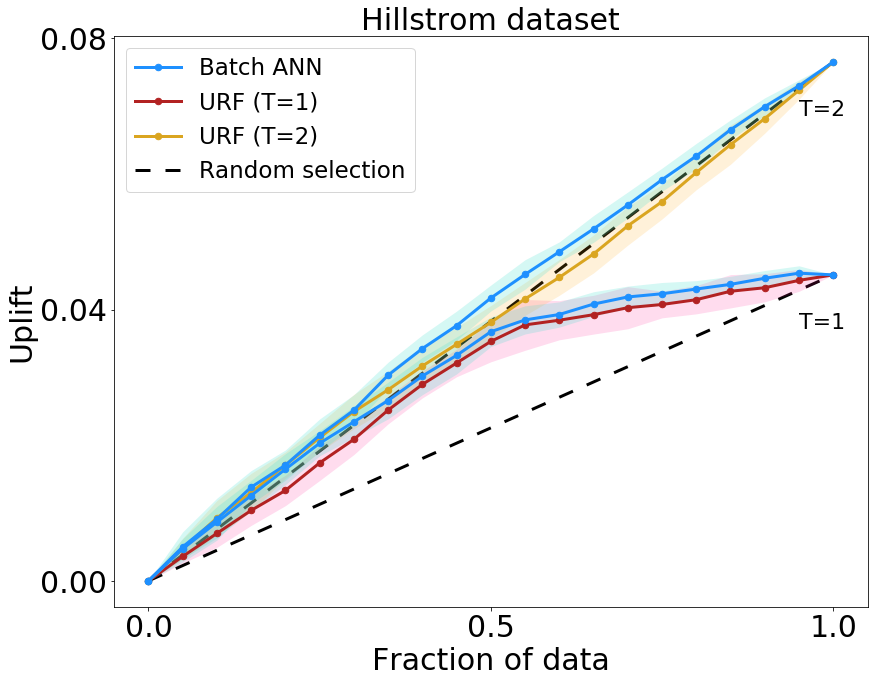

In [115]:
ax1 = plotting([treats_w, treats_m], [resps_w, resps_m], [nets_w, nets_m], [forests_w, forests_m], 
               urf_label=['URF (T=1)', 'URF (T=2)'], 
               urf_colors=['firebrick', 'goldenrod'], 
               urf_colors_bands=['deeppink', 'orange'],
               treatment_names=['T=1', "T=2"],
               yticks=[0, .04, .08])

In [111]:
ax1.figure.savefig('10runs_multitreat_w_m_1.pdf', bbox_inches='tight', pad_inches=0)